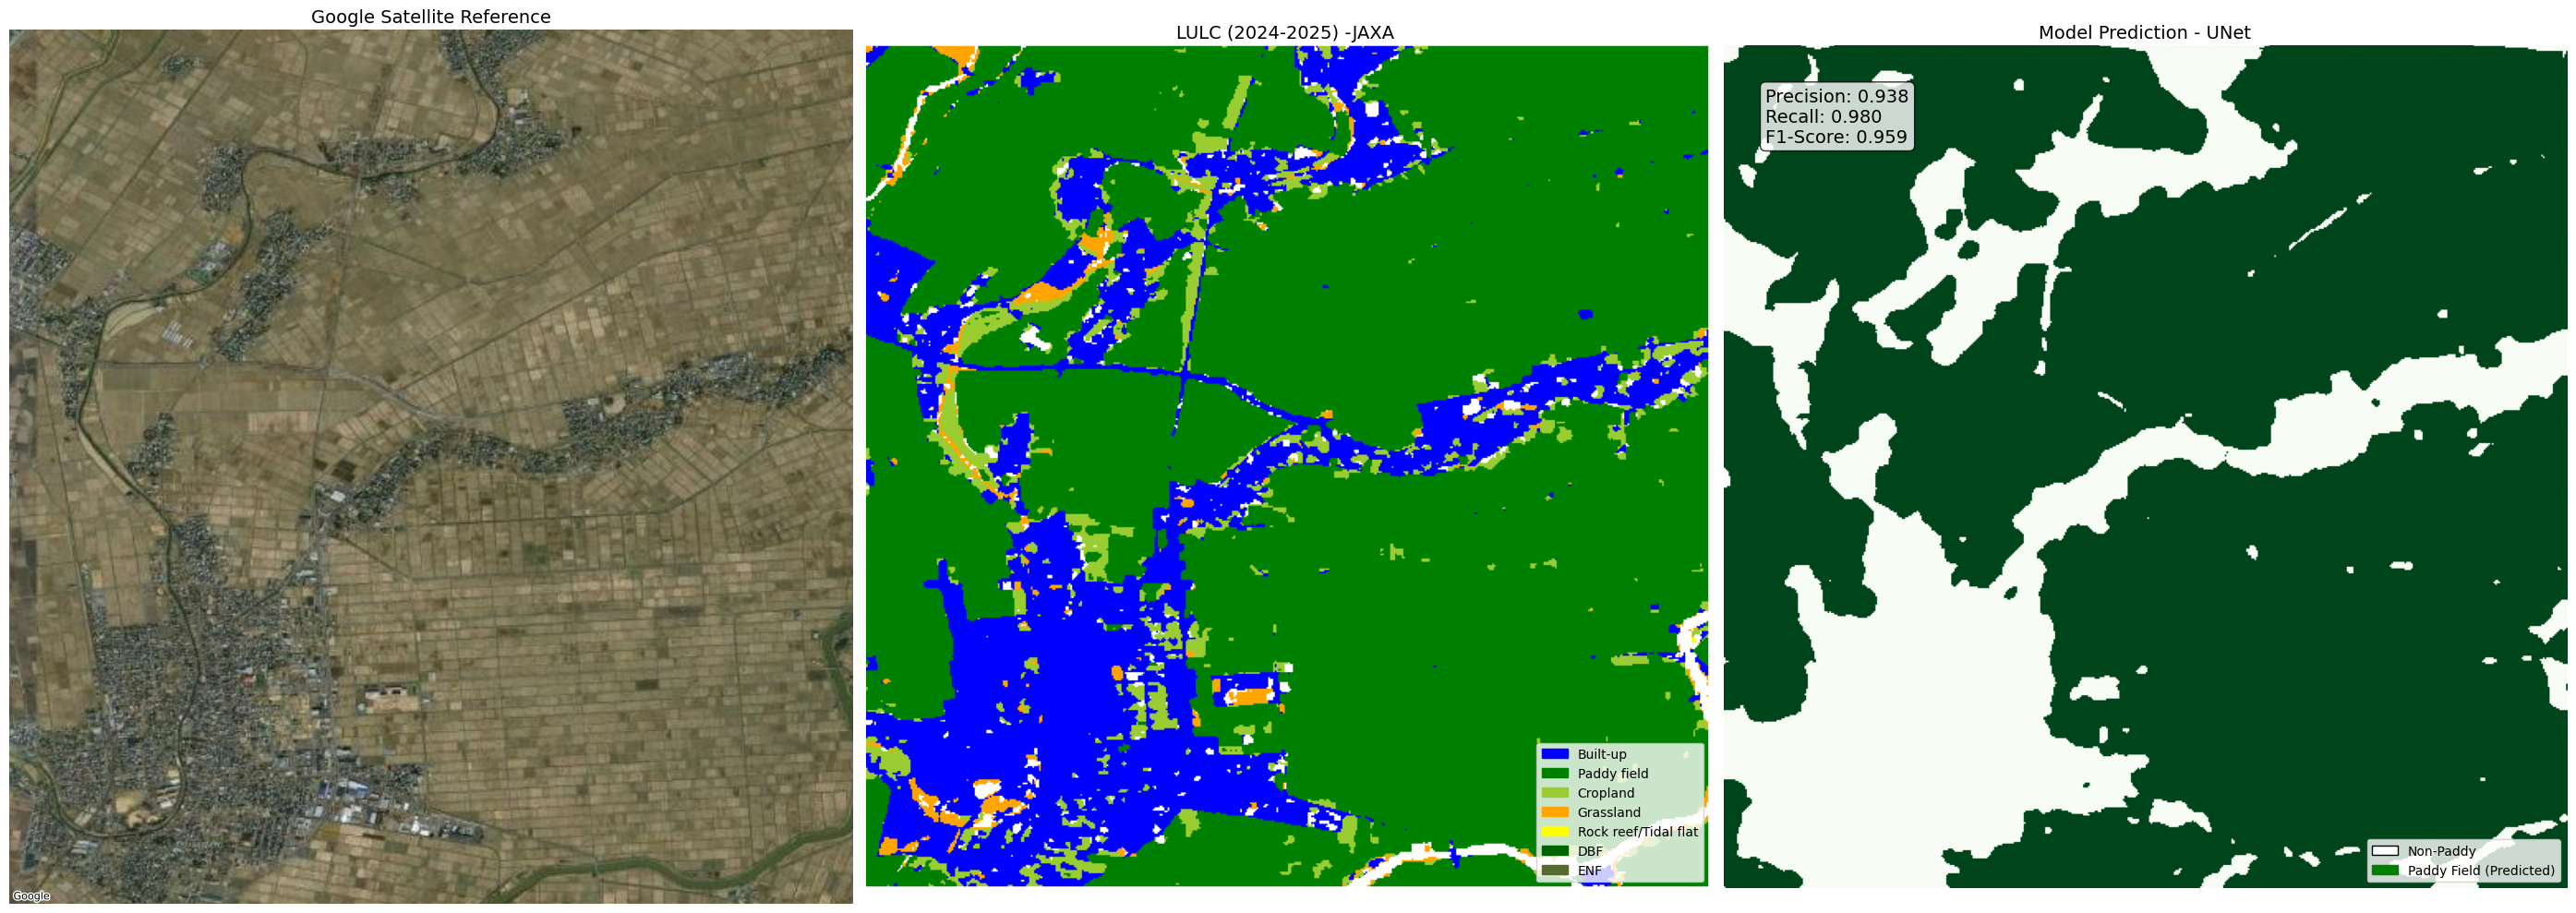

In [21]:
import rasterio
import rasterio.mask
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import contextily as cx
import geopandas as gpd
from shapely.geometry import box
import xyzservices.lib as xyz
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
from skimage.transform import resize # For fixing the shape mismatch

# --- 1. Define LULC Mapping (Updated to your list) ---
lulc_labels = {
    1: "Built-up", 2: "Paddy field", 3: "Cropland", 4: "Grassland",
    5: "Rock reef/Tidal flat", 6: "DBF", 7: "DNF", 8: "EBF", 9: "ENF",
}

lulc_colors = {
    1: 'blue', 2: 'green', 3: 'yellowgreen', 4: 'orange', 5: 'yellow',
    6: 'darkgreen', 7: 'forestgreen', 8: 'red', 9: 'darkolivegreen',
}

# --- 2. Setup Google Satellite Provider ---
google_satellite = xyz.TileProvider(
    name="GoogleSatellite",
    url="https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}",
    attribution="Google"
)

# --- 3. Load Prediction Data ---
with rasterio.open(r'G:\data\models\test_2.tif') as src:
    pred_data = src.read(1)
    pred_binary = (pred_data > 0.5).astype(int) 
    target_shape = pred_binary.shape # This is the shape we need to match
    bbox = src.bounds
    gdf_bounds = gpd.GeoDataFrame({'geometry': [box(*bbox)]}, crs=src.crs)
    gdf_3857 = gdf_bounds.to_crs(epsg=3857)
    west, south, east, north = gdf_3857.total_bounds

# --- 4. Load LULC and FIX SHAPE MISMATCH ---
with rasterio.open(r'C:\Users\venka\workspace\projects\dump\paddy_identification\data\processed\labels\nigata_merge.tif') as lulc_src:
    bounds_for_lulc = gdf_bounds.to_crs(lulc_src.crs)
    lulc_data_raw, _ = rasterio.mask.mask(lulc_src, bounds_for_lulc.geometry, crop=True)
    lulc_data_raw = lulc_data_raw[0]

    # Create Ground Truth binary: 1 if LULC == 2 (Paddy), else 0
    gt_binary_raw = (lulc_data_raw == 3).astype(float)
    
    # CRUCIAL FIX: Resize Ground Truth to match Prediction shape exactly
    # order=0 is 'nearest neighbor' to keep values as strictly 0 or 1
    gt_binary = resize(gt_binary_raw, target_shape, order=0, preserve_range=True, anti_aliasing=False).astype(int)
    
    # Also resize lulc_data for plotting consistency (optional but cleaner)
    lulc_data_resized = resize(lulc_data_raw.astype(float), target_shape, order=0, preserve_range=True).astype(int)

# --- 5. Calculate Metrics (Now shapes match!) ---
y_true = gt_binary.flatten()
y_pred = pred_binary.flatten()

precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

# --- 6. Plotting ---
fig, axes = plt.subplots(1, 3, figsize=(28, 10))

# Panel 1: Google Satellite
axes[0].set_title("Google Satellite Reference", fontsize=14)
axes[0].set_xlim(west, east)
axes[0].set_ylim(south, north)
cx.add_basemap(axes[0], source=google_satellite)

# Panel 2: LULC8
axes[1].set_title("LULC (2024-2025) -JAXA ", fontsize=14)
unique_values = np.unique(lulc_data_resized)
present_colors = [lulc_colors.get(val, 'white') for val in unique_values]
im1 = axes[1].imshow(lulc_data_resized, extent=[bbox.left, bbox.right, bbox.bottom, bbox.top], 
                     cmap=ListedColormap(present_colors))

patches = [mpatches.Patch(color=lulc_colors[val], label=lulc_labels[val]) for val in unique_values if val in lulc_labels]
axes[1].legend(handles=patches, loc='lower right',  fontsize=10)

# Panel 3: Prediction & Metrics
axes[2].set_title("Model Prediction - UNet", fontsize=14)
axes[2].imshow(pred_binary, extent=[bbox.left, bbox.right, bbox.bottom, bbox.top], cmap='Greens')

# Legend with white for Non-Paddy
pred_patches = [
    mpatches.Patch(color='white', ec='black', label='Non-Paddy'),
    mpatches.Patch(color='green', label='Paddy Field (Predicted)')
]
axes[2].legend(handles=pred_patches, loc='lower right')

# Add Metrics Text Box
stats_text = f"Precision: {precision:.3f}\nRecall: {recall:.3f}\nF1-Score: {f1:.3f}"
axes[2].text(0.05, 0.95, stats_text, transform=axes[2].transAxes, fontsize=14,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

for ax in axes:
    ax.set_axis_off()

plt.tight_layout()
plt.show()